# Explorative analysis for extrapolation of cic savings data across multiple years

- Determine average temperature on certain days / months vs. average temperatures that we have measured.
- Extrapolate expected temperatures based on this comparison
- Determine heat demand based on these temperatures
- with COP / temperature and %-by-hp / temperature determine heat by hp extrapolated and energy consumption extrapolated


Inputs:  
etmgeg_260.txt: text file containing KNMI weather measurements in the Bilt 1901-aug2023

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from urllib.parse import urlparse
import pymysql
import os
import importlib
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

importlib.reload(sns)

<module 'seaborn' from '/Users/noutneijmeijer/Documents/quatt_data_analysis/.venv/lib/python3.11/site-packages/seaborn/__init__.py'>

# load data

In [4]:
# load temperature data from file
with open('./data/etmgeg_260.txt','r') as f:
    content = f.readlines()
    header = content[51].split(',')
    header = [h.strip() for h in header]
    data = [line.split(',') for line in content[53:-1]]

    df_knmi = pd.DataFrame(columns=header, data=data)

In [5]:
# get data from mysql or local
if os.path.isfile('./data/cic_data.csv'):
    # load csv file
    df_cic = pd.read_csv('./data/cic_data.csv')

else:
    MYSQL_URL = os.environ['MYSQLDEV']
    parsed_mysql_url = urlparse(MYSQL_URL)

    try:
        connection = pymysql.connect(host=parsed_mysql_url.hostname,
                                    user=parsed_mysql_url.username,
                                    password=parsed_mysql_url.password,
                                    database=parsed_mysql_url.path[1:],
                                    port=parsed_mysql_url.port,
                                    autocommit=True)
        cursor = connection.cursor()
        if cursor.connection:
            # get energyConsumption
            cursor.execute('''SELECT * FROM cic_data_daily''')
            fields = [field_md[0] for field_md in cursor.description]
            result = [dict(zip(fields,row)) for row in cursor.fetchall()]
            df_cic = pd.DataFrame(result)
            df_cic.to_csv('./data/cic_data.csv', index=False)
    except:
        print("Error while connecting to MySQL")
    finally:
        cursor.close()
        connection.close()

In [194]:
# load expected savings data:
df_savings = pd.read_csv('./data/EnergyConsumption_test_data2.csv')
df_hubspot = pd.read_csv('./data/hubspot_data.csv')
df_cic_prod = pd.read_csv('./data/prod_cic.csv')

# merge df_savings with df_cic
df_hubspot['orderNr'] = df_hubspot['Deal Name'].str.extract(r'.*(QUATT\d+)')
df_savings = pd.merge(df_savings, df_cic_prod, left_on='orderNr', right_on='orderNumber', how='left')
df_savings = pd.merge(df_savings, df_hubspot, left_on='orderNr', right_on='orderNr', how='left')
df_cic = pd.merge(df_cic, df_savings, left_on='cic_id', right_on='id_y', how='left')



/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_38001/3972633972.py:10: FutureWarning: Passing 'suffixes' which cause duplicate columns {'updated_at_x', 'created_at_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_cic = pd.merge(df_cic, df_savings, left_on='cic_id', right_on='id_y', how='left')


# explore temperature

In [7]:
# add date columns to dataset
df_knmi['date'] = pd.to_datetime(df_knmi['YYYYMMDD'], format='%Y%m%d')
df_knmi['TG'] = df_knmi['TG'].astype(float)/10
df_knmi['year'] = df_knmi['date'].dt.year
df_knmi['month'] = df_knmi['date'].dt.month
df_knmi['day'] = df_knmi['date'].dt.day
df_knmi['month-day'] = df_knmi['date'].dt.strftime('%m-%d')

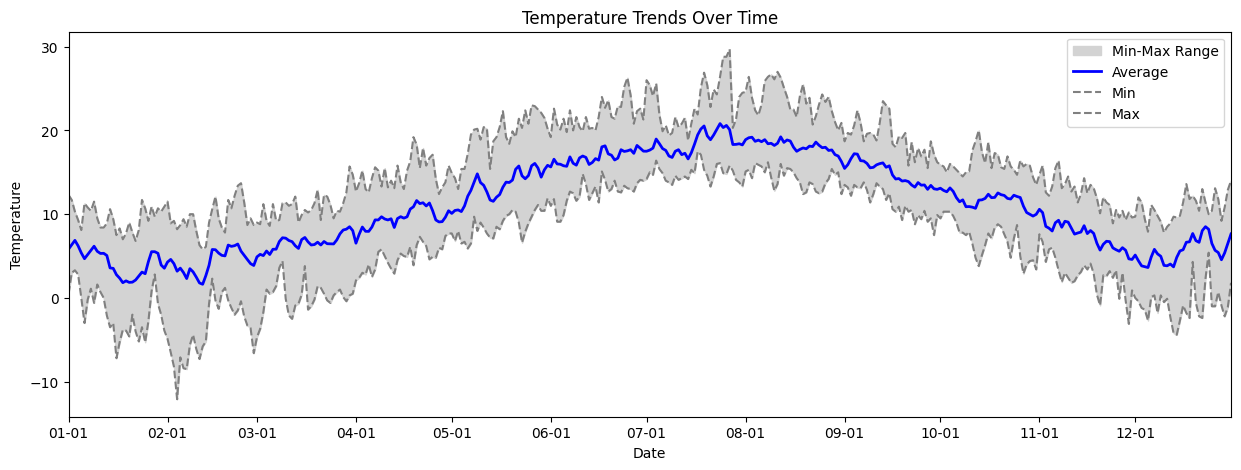

In [8]:
# create new dataframe with average temperature per day (for last 10 years)
df_year=pd.DataFrame()
df_year['month-day'] = df_knmi[df_knmi['year']==2022]['month-day']
# set month-day as index of frame
df_year = df_year.set_index('month-day')
for year in range(2012, 2023):
    df_year[f'TG-{year}'] = df_knmi[(df_knmi['year']==year) & (df_knmi['month-day']!='02-29')]['TG'].values

df_year['TG-avg'] = df_year.mean(axis=1)
df_year['TG-min'] = df_year.min(axis=1)
df_year['TG-max'] = df_year.max(axis=1)

# Plot temperature trend of the last 10 years
df_year['Date'] = pd.to_datetime(df_year.index, format='%m-%d')

# Plotting
plt.figure(figsize=(15, 5))

plt.fill_between(df_year['Date'], df_year['TG-min'], df_year['TG-max'], color='lightgrey', label='Min-Max Range')
plt.plot(df_year['Date'], df_year['TG-avg'], color='blue', linewidth=2, label='Average')
plt.plot(df_year['Date'], df_year['TG-min'], color='grey', linestyle='--', label='Min')
plt.plot(df_year['Date'], df_year['TG-max'], color='grey', linestyle='--', label='Max')


# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Trends Over Time')
plt.legend()

# Set x-axis limits to the minimum and maximum date values
plt.xlim(df_year['Date'].min(), df_year['Date'].max())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Show the plot
plt.show()

In [9]:
# Estimate and plot heat demand based on degree days
# assuming that: heat demand will go up linearly with temperature, however it's influenced by a factor which is dependant on the month (weighted degree days)
# add measured temperature to our dataframe
min_date = df_cic['date'].min()
max_date = df_cic['date'].max()

# make df_cic_avg dataframe which has all unique dates in df_cic as index ordered ascending
df_cic_avg = pd.DataFrame()
df_cic_avg['date'] = pd.date_range(min_date, max_date)

# for each date add the average min temp, average max temp, average average temp, and row count
df_cic_avg['temp_min'] = df_cic.groupby('date')['outside_temperature_min'].mean().values
df_cic_avg['temp_min_std'] = df_cic.groupby('date')['outside_temperature_min'].std().values
df_cic_avg['temp_max'] = df_cic.groupby('date')['outside_temperature_max'].mean().values
df_cic_avg['temp_max_std'] = df_cic.groupby('date')['outside_temperature_max'].std().values
df_cic_avg['temp_avg'] = df_cic.groupby('date')['outside_temperature_avg'].mean().values
df_cic_avg['temp_avg_std'] = df_cic.groupby('date')['outside_temperature_avg'].std().values
df_cic_avg['row_count'] = df_cic.groupby('date')['outside_temperature_avg'].count().values
df_cic_avg = pd.merge(df_cic_avg, df_knmi[['date','TG']], on = 'date', how='left')

# calculate differences between measured temperatures
df_cic_avg['temp_avg_diff'] = df_cic_avg['temp_avg'] - df_cic_avg['TG']

In [10]:
df_cic_avg['temp_avg_diff'].mean()

1.2751025603957795

In [11]:
df_cic_avg[df_cic_avg['row_count']>15]['date'].min()

Timestamp('2022-11-30 00:00:00')

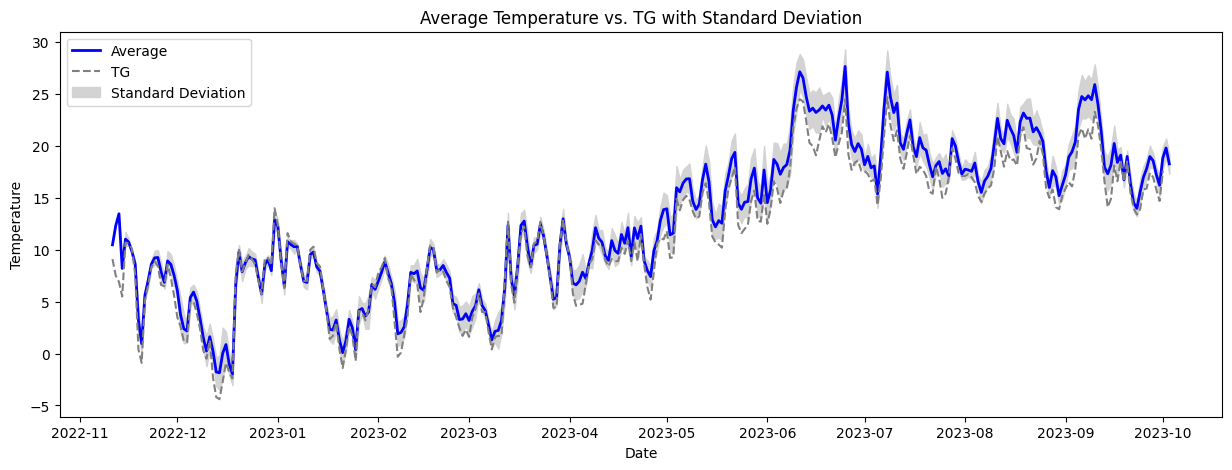

In [61]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot average temperature
plt.plot(df_cic_avg['date'], df_cic_avg['temp_avg'], color='blue', linewidth=2, label='Average')

# Plot TG
plt.plot(df_cic_avg['date'], df_cic_avg['TG'], color='grey', linestyle='--', label='TG')

# Plot standard deviation as a shaded area
plt.fill_between(df_cic_avg['date'],
                 df_cic_avg['temp_avg'] - df_cic_avg['temp_avg_std'],
                 df_cic_avg['temp_avg'] + df_cic_avg['temp_avg_std'],
                 color='lightgrey', label='Standard Deviation')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Average Temperature vs. TG with Standard Deviation')
plt.legend()

# Show the plot
plt.show()

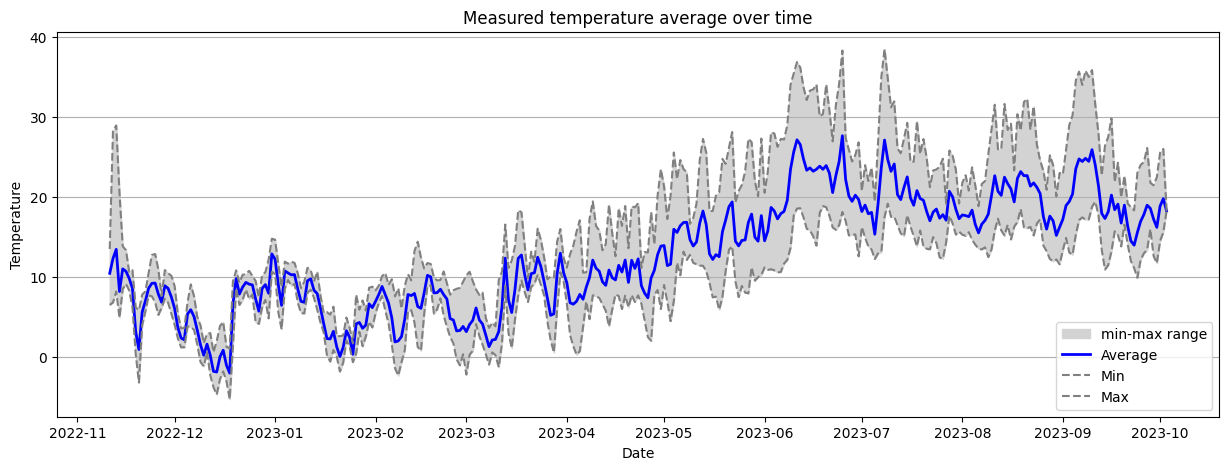

In [65]:
# Plotting
plt.figure(figsize=(15, 5))

# Plot standard deviation as a shaded area
plt.fill_between(df_cic_avg['date'],
                 df_cic_avg['temp_min'],
                 df_cic_avg['temp_max'],
                 color='lightgrey', label='min-max range')

# Plot average temperature
plt.plot(df_cic_avg['date'], df_cic_avg['temp_avg'], color='blue', linewidth=2, label='Average')
plt.plot(df_cic_avg['date'], df_cic_avg['temp_min'], color='grey', linestyle='--', label='Min')
plt.plot(df_cic_avg['date'], df_cic_avg['temp_max'], color='grey', linestyle='--', label='Max')

# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Measured temperature average over time')
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()

KeyError: 'plotting_date'

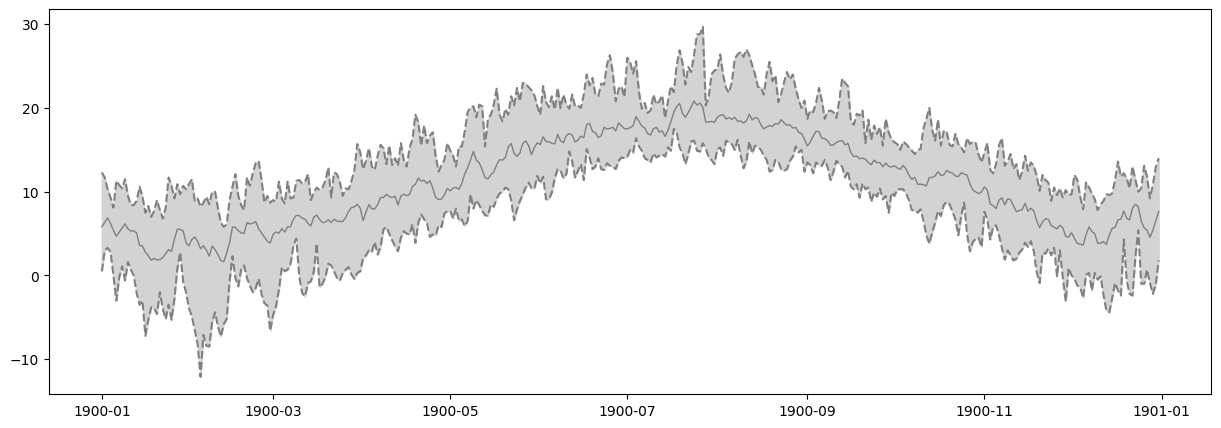

In [13]:
# Plotting
plt.figure(figsize=(15, 5))

plt.fill_between(df_year['Date'], df_year['TG-min'], df_year['TG-max'], color='lightgrey', label='Min-Max Range')
plt.plot(df_year['Date'], df_year['TG-avg'], color='grey', linewidth=1, label='Average')
plt.plot(df_year['Date'], df_year['TG-min'], color='grey', linestyle='--', label='Min')
plt.plot(df_year['Date'], df_year['TG-max'], color='grey', linestyle='--', label='Max')
# Plot average temperature measured
plt.plot(df_cic_avg['plotting_date'], df_cic_avg['temp_avg'], color='blue', linewidth=2, label='Average')
# Plot TG
plt.plot(df_cic_avg['plotting_date'], df_cic_avg['TG'], color='black', linestyle='--', label='TG')
# Plot standard deviation as a shaded area
plt.fill_between(df_cic_avg['plotting_date'],
                 df_cic_avg['temp_avg'] - df_cic_avg['temp_avg_std'],
                 df_cic_avg['temp_avg'] + df_cic_avg['temp_avg_std'],
                 color='lightblue', label='Standard Deviation')


# Adding labels and legend
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature Trends Over Time')
plt.legend()

# Set x-axis limits to the minimum and maximum date values
plt.xlim(df_year['Date'].min(), df_year['Date'].max())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

# Show the plot
plt.show()

In [ ]:
df_cic_avg['plotting_date']  = pd.to_datetime(df_cic_avg['date'].dt.strftime('%m-%d'), format='%m-%d')
# df_year['Date']

Index(['cic_id', 'created_at_x', 'updated_at_x', 'date', 'hp1_energy_consumed',
       'hp1_heat_generated', 'hp1_active', 'hp2_energy_consumed',
       'hp2_heat_generated', 'hp2_active',
       ...
       'numberOfHeatPumps', 'earlyNightPricing', 'heat_delivered',
       'hp_heat_generated', 'hp_energy_consumed', 'month', 'dd_month',
       'aardgas_verbruik_cat', 'perc_by_hp', 'COP'],
      dtype='object', length=137)

# Clean up and select installation features
Possible features to use (of house)
- referentie_warmtevraag_per_m2; numberical(67-110)
- geschiktheid_woning; categorical (uitmuntend, zeer geschikt, goed geschikt, geschikt, matig geschikt)
- aardgas_verbruik; numerical  
    Contains 9999 and 1 values -> filter out < ? and higher than >?, Imputation of these vars probably would not do any good  
- bouwjaar; categorical (Voor 1970, Tussen 1970 en 1990, Tussen 1990 en 2000, Na 2000)  
    Needs to be cleaned;  
- woning_type; categorical(Vrijstaand, 2-onder-1-kap, Tussenwoning, Hoekwoning, Appartement)
- oppervlakte; numerical (10-750), not sure if this is good
- afgiftesysteem; categorical (Radiatoren, Vloerverwarming, Convectoren in de vloer, Convectoren aan de wand, Anders)
- geschiktheidscategorie Numerical ? (1-5), is probably categorical instead of numerical
- referentie_warmtevraag; Numerical(750.63 - 50250)
- stookgrens; numerical / categorical (13, 15, 16, 17)
- ...

- add 24hr outside temperature
  

muurisolatie, spouwmuurisolatie, Vloerisolatie, Dakisolatie, 
dubbelglas, HR++ glas, 
Thermostaat, 
Woning comfort, Zone,
Gasverbruik, Stadswarmteverbruik,
Woningtype,
Afgiftesysteem,
Afmeting woning,
numberOfHeatPumps,


In [192]:
df_cic['usePricingToLimitHeatPump'].isna().sum() # what value is used for missing values?

KeyError: 'usePricingToLimitHeatPump'

In [195]:
df_cic['date'] = pd.to_datetime(df_cic['date'], format='%Y-%m-%d')


# add heat demand and month to dataframe
df_cic['heat_delivered'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated', 'boiler_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_heat_generated'] = df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1).astype(float)
df_cic['hp_energy_consumed'] = df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1).astype(float)
df_cic['perc_by_hp'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic['heat_delivered']).astype(float)
df_cic['COP'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)
df_cic['month'] = df_cic['date'].dt.month
df_cic['dd_month'] = df_cic['month'].apply(lambda x: 0.8 if x in [4, 5, 6, 7, 8, 9] else (1 if x in [3, 10] else 1.1))
df_cic['aardgas_verbruik_cat'] = df_cic['aardgas_verbruik'].apply(lambda x: 0 if x < 1000 else (1 if x < 2000 else (2 if x < 3000 else 3)))
df_cic['outside_temperature_avg'] = df_cic['outside_temperature_avg'].astype(float)

In [212]:
# filling Nan values
df_cic['numberOfHeatPumps'].fillna(1, inplace=True)
df_cic['Zone regeling'].fillna('Nee', inplace=True)

# preprocess hubspot data
# merge 'Weet niet' and 'Weet ik niet' and 'nan' values to -> unkown
replacement_dict = {None: 'unknown', 
                    'Weet niet': 'unknown',
                    'Weet ik niet': 'unknown'}
df_cic.replace({'Spouwmuurisolatie': replacement_dict,
                    'Muurisolatie aan de binnen- of buitenkant': replacement_dict,
                    'Dakisolatie': replacement_dict,
                    'Vloerisolatie': replacement_dict,
                    'Dubbel glas': replacement_dict,
                    'HR++ glas': replacement_dict,
                    }, inplace=True)

# rename long column
df_cic.rename(columns={'Muurisolatie aan de binnen- of buitenkant': 'Muurisolatie'}, inplace=True)

In [199]:
df_hubspot.columns

Index(['Record ID', 'Deal Name', '8kw', 'Aardgas', 'Afgiftesysteem',
       'Afmetingen van het huis', 'Ander verwarmingssysteem',
       'Ander verwarmingssysteem [Anders]', 'Bouwjaar', 'Dakisolatie',
       'Dubbel glas', 'Elektriciteit', 'CV ketel plaats', 'Grootverbruikers',
       'Hoofdverwarmingssysteem', 'HR++ glas', 'Ketel jaar', 'Ketel merk',
       'Ketel type', 'Muurisolatie aan de binnen- of buitenkant',
       'Spouwmuurisolatie', 'Thermostaat', 'Thermostaat [Anders]',
       'Thermostaat type', 'Verwarmingsinstallatie', 'Vloerisolatie', 'Warmte',
       'Woning comfort', 'Woningtype', 'Zolder verdieping', 'Zone regeling',
       'orderNr'],
      dtype='object')

In [204]:
df_hubspot['Zolder verdieping'].value_counts()

2                        1324
2e                        129
3                         125
1                          49
2de                        21
                           20
 -                         19
4                          12
3e                         11
2e verdieping               7
Tweede                      6
1e                          6
/                           5
0                           5
                            3
2de etage                   2
3de                         2
Derde                       2
Niet van toepassing         2
begane grond                2
.                           2
1ste                        2
1 floor                     2
attic                       2
Nvt                         1
eerste                      1
Eerste verdieping           1
²                           1
32                          1
2 e                         1
Begane grond                1
2 de verdieping             1
2 (bg=0)                    1
Eerste/twe

In [291]:
# copy only rows with correct features
X = (df_cic[
      #   (df_cic['outside_temperature_avg'].round(0)==12) &
      #   (df_cic['aardgas_verbruik']>100) &
      #   (df_cic['aardgas_verbruik']<6000) &
        (df_cic['outside_temperature_avg'].notna()) &
        (df_cic['Elektriciteit'].notna()) &
        (df_cic['bouwjaar'].isin(['Voor 1970',
                                  'Tussen 1970 en 1990',
                                  'Tussen 1990 en 2000',
                                  'Na 2000']))]
                                  # feature list
                                  [[
                                      # features from cic measurements
                                      'outside_temperature_avg',
                                      'outside_temperature_min',
                                      'outside_temperature_max',
                                      # features from cic data
                                      'numberOfHeatPumps',
                                      # features from savings calc.
                                      'referentie_warmtevraag_per_m2',
                                      'geschiktheid_woning',  # remove
                                      'aardgas_verbruik',
                                      'bouwjaar',
                                      'woning_type',
                                      'oppervlakte',
                                      'afgiftesysteem',
                                      'geschiktheidscategorie',  # remove
                                      'referentie_warmtevraag',
                                      'stookgrens',  # remove
                                      # features from hubspot
                                      'Spouwmuurisolatie',
                                      'Muurisolatie',
                                      'Dakisolatie',
                                      'Vloerisolatie',
                                      'Dubbel glas',
                                      'HR++ glas',
                                      'Zone regeling',
                                      'Woning comfort',
                                      'Elektriciteit'
                                      ]]
)

# 1 hot encode categorical features
X = pd.merge(X, X['afgiftesysteem'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
X = pd.merge(X, X['Woning comfort'].str.replace('; ',';').str.get_dummies(sep=';'), left_index=True, right_index=True)
X = pd.merge(X, pd.get_dummies(X[['geschiktheidscategorie',
                                  'stookgrens']].astype(str)), 
                                  left_index=True, right_index=True)
X = pd.merge(X, pd.get_dummies(X[[
                                    'geschiktheid_woning',
                                  'bouwjaar',
                                  'woning_type',
                                  'Spouwmuurisolatie',
                                  'Muurisolatie',
                                  'Dakisolatie',
                                  'Vloerisolatie',
                                  'Dubbel glas',
                                  'HR++ glas',
                                  'Zone regeling']]), 
                                  left_index=True, right_index=True)



# remove categorical features
X = X.drop(['afgiftesysteem',
            'geschiktheid_woning',
            'bouwjaar',
            'woning_type',
            'Spouwmuurisolatie',
            'Muurisolatie',
            'Dakisolatie',
            'Vloerisolatie',
            'Dubbel glas',
            'HR++ glas',
            'Zone regeling',
            'Woning comfort',
            'geschiktheidscategorie',
            'stookgrens'
            ], axis=1)

# rename long columns names
X.columns = X.columns.str.replace(r"(.*)Ja \(meer dan 10 jaar geleden geplaatst\)", r"\1Ja >10")
X.columns = X.columns.str.replace(r"(.*)Ja \(minder dan 10 jaar geleden geplaatst\)", r"\1Ja <10")



# select target variable
y =  (df_cic[
      #   (df_cic['outside_temperature_avg'].round(0)==12) &
      #   (df_cic['aardgas_verbruik']>100) &
      #   (df_cic['aardgas_verbruik']<6000) &
        (df_cic['outside_temperature_avg'].notna()) &
        (df_cic['Elektriciteit'].notna()) &
        (df_cic['bouwjaar'].isin(['Voor 1970',
                                  'Tussen 1970 en 1990',
                                  'Tussen 1990 en 2000',
                                  'Na 2000']))]
                                  [['hp_heat_generated']] #,
                                    # 'COP',
                                    # 'perc_by_hp',
                                    # 'hp_energy_consumed']]
)
y = np.max([y, np.zeros(y.shape)], axis=0) # replace negative values with 0

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_38001/2101285467.py:83: FutureWarning: The default value of regex will change from True to False in a future version.
  X.columns = X.columns.str.replace(r"(.*)Ja \(meer dan 10 jaar geleden geplaatst\)", r"\1Ja >10")
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_38001/2101285467.py:84: FutureWarning: The default value of regex will change from True to False in a future version.
  X.columns = X.columns.str.replace(r"(.*)Ja \(minder dan 10 jaar geleden geplaatst\)", r"\1Ja <10")


In [253]:
X_y = pd.merge(X, y, left_index=True, right_index=True)

## plotting 

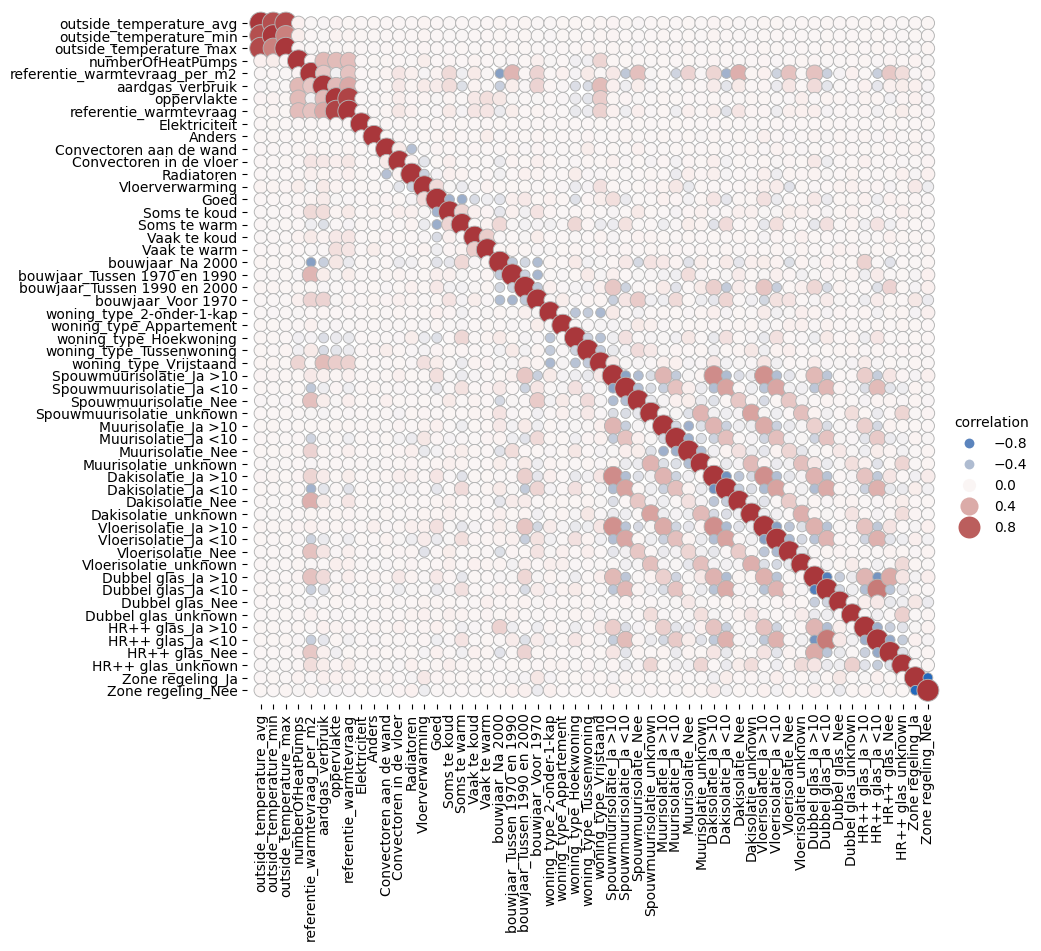

In [254]:
# plot correlation matrix
corr = X.corr().stack().reset_index(name="correlation")


g = sns.relplot(
    data=corr,
    x="level_0", y="level_1", hue="correlation", size="correlation",
    palette="vlag", hue_norm=(-1, 1), edgecolor=".7",
    height=10, sizes=(50, 250), size_norm=(-.2, .8),
)

# Tweak the figure to finalize
g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True)
g.ax.margins(.02)
for label in g.ax.get_xticklabels():
    label.set_rotation(90)

# some features are very highly correlated, we might be able to remove them.
# are they collected or calculated features?
# referentie warmtevraag per m2- oppervlak
# geschiktheid woning - geschiktheidscategorie
# stookgrens - geschiktheidscategorie & geschiktheid woning

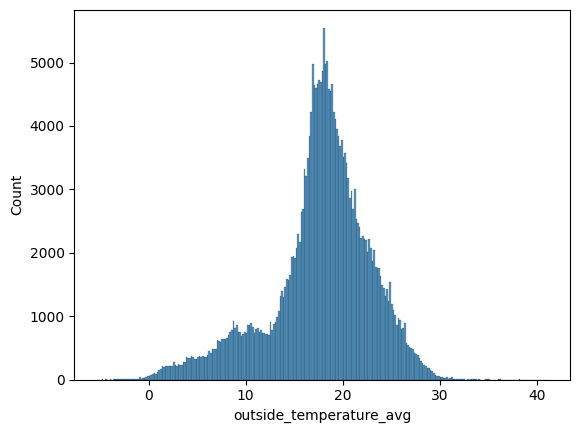

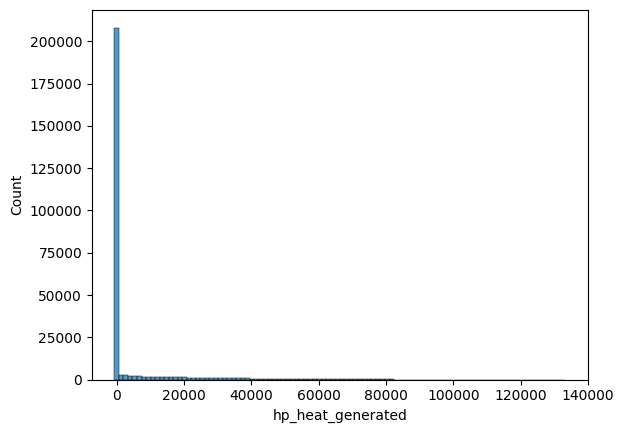

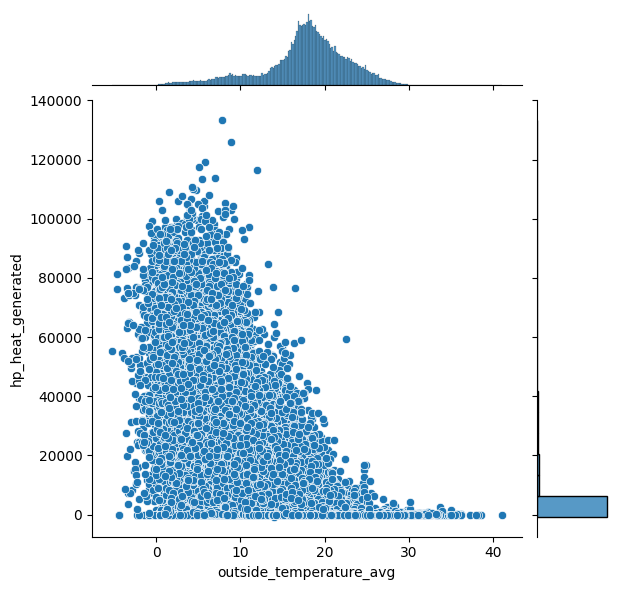

In [255]:
# histograms of temperature
sns.histplot(data=X, x="outside_temperature_avg", multiple="stack")
plt.show()

# histogram of heat generated
sns.histplot(data=y, x="hp_heat_generated", multiple="stack", bins=100)
plt.show()

sns.jointplot(data=X_y, x="outside_temperature_avg", y="hp_heat_generated")
plt.show()

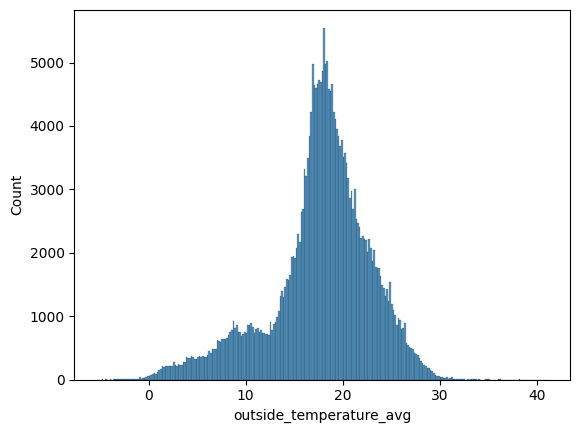

In [256]:
# histograms of temperature
sns.histplot(data=X, x="outside_temperature_avg", multiple="stack")
plt.show()


## feature selection

In [ ]:
# test train split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=1234)

## Random forest

In [265]:
len(X_train[X_train['outside_temperature_avg'].round(0)==12])
print(X_train.shape)

(3525, 54)


In [287]:
# random forest regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

regr = RandomForestRegressor(n_estimators = 20,
                             max_depth=20, 
                             random_state=0,
                             criterion='absolute_error')
regr.fit(X_train[X_train['outside_temperature_avg'].round(0)==12], y_train.ravel())


RandomForestRegressor(criterion='absolute_error', max_depth=20, n_estimators=20,
                      random_state=0)

array([[<Axes: title={'center': 'hp_heat_generated'}>]], dtype=object)

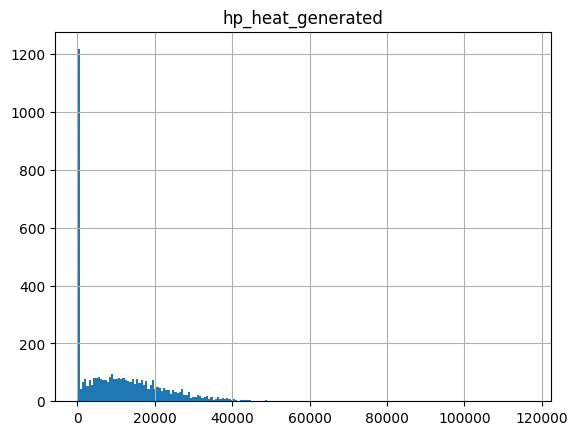

In [262]:
y.hist(bins=200)

Mean Absolute Error: 7078.282878758844
Mean Squared Error: 83496111.12842475


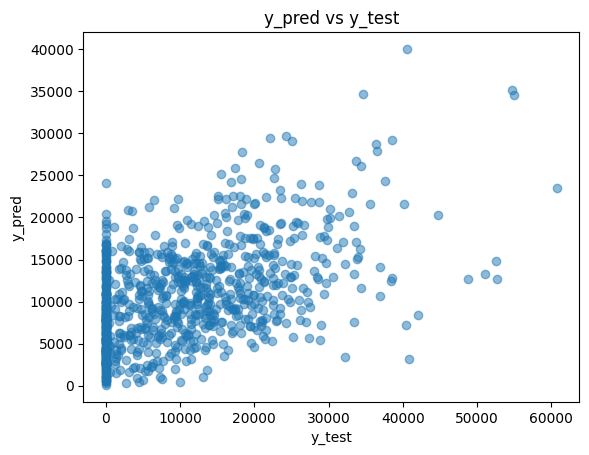

,feature,importance
0,outside_temperature_max,0.146645
1,outside_temperature_avg,0.140851
2,outside_temperature_min,0.125997
3,aardgas_verbruik,0.124209
4,Elektriciteit,0.063773
5,referentie_warmtevraag,0.061892
6,oppervlakte,0.047659
7,referentie_warmtevraag_per_m2,0.028044
8,Vloerverwarming,0.010519
9,bouwjaar_Voor 1970,0.009924


In [288]:
# predict on test set
y_pred = regr.predict(X_test)

# mesure performance
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))

# plot feature importance
feature_importance = pd.DataFrame()
feature_importance['feature'] = X_train.columns
feature_importance['importance'] = regr.feature_importances_
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance.reset_index(inplace=True, drop=True)

# scatter y_pred vs y_test
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.title('y_pred vs y_test')
plt.show()

# Plotting
feature_importance

Now, we check how much heat is produced at certain outdoor temperatures and at certain days of the year.
We want to know the relation between heat demand and temperature and heat demand and month.  


Possible features to use
- referentie_warmtevraag_per_m2; numberical(67-110)
- geschiktheid_woning; categorical (uitmuntend, zeer geschikt, goed geschikt, geschikt, matig geschikt)
- aardgas_verbruik; numerical  
    Contains 9999 and 1 values -> filter out < ? and higher than >?, Imputation of these vars probably would not do any good 
- bouwjaar; categorical (Voor 1970, Tussen 1970 en 1990, Tussen 1990 en 2000, Na 2000)  
    Needs to be cleaned;  
- woning_type; categorical(Vrijstaand, 2-onder-1-kap, Tussenwoning, Hoekwoning, Appartement)
- oppervlakte; numerical (10-750), not sure if this is good
- afgiftesysteem; categorical (Radiatoren, Vloerverwarming, Convectoren in de vloer, Convectoren aan de wand, Anders) Leave out 'Anders'?
- geschiktheidscategorie Numerical ? (1-5), is probably categorical instead of numerical
- referentie_warmtevraag; Numerical(750.63 - 50250)
- stookgrens; numerical / categorical (13, 15, 16, 17)

<Axes: >

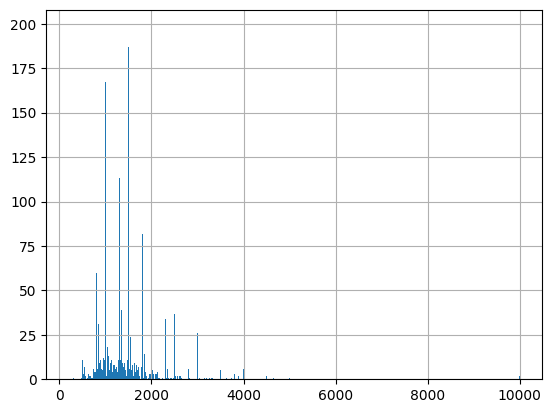

In [68]:
df_savings['aardgas_verbruik'].hist(bins=1000)

In [25]:
df_savings.columns

Index(['id_x', 'created_at', 'updated_at', 'deal_id', 'orderNr',
       'aanbevolen_vermogen_warmtepomp', 'referentie_warmtevraag_per_m2',
       'geschiktheid_woning', 'aardgas_verbruik', 'bouwjaar', 'woning_type',
       'oppervlakte', 'afgiftesysteem', 'geschiktheidscategorie',
       'referentie_warmtevraag', 'gas_tbv_tapwater',
       'verbruik_gas_tbv_ruimteverwarming',
       'warmtevraag_woning_op_basis_van_verbruik',
       'vermogen_nodig_woning_warmteverlies_huis', 'stookgrens',
       'vermogen_op_basis_van_verbruik', 'beta_03', 'beta_07',
       'aanbevolen_vermogen_op_basis_van_beta_03',
       'aanbevolen_vermogen_op_basis_van_beta_07', 'vollasturen_max',
       'uren_boven_max', 'percentage_vollasturen_boven_max', 'vermogen',
       'beta_factor', 'dekking_warmtevraag_op_basis_van_woning',
       'dekking_warmtevraag_op_basis_van_beta_factor',
       'dekking_warmtevraag_totaal', 'dekking_warmtevraag_met_wp_theoretisch',
       'dekking_warmtevraag_van_warmtepomp', 'SPF

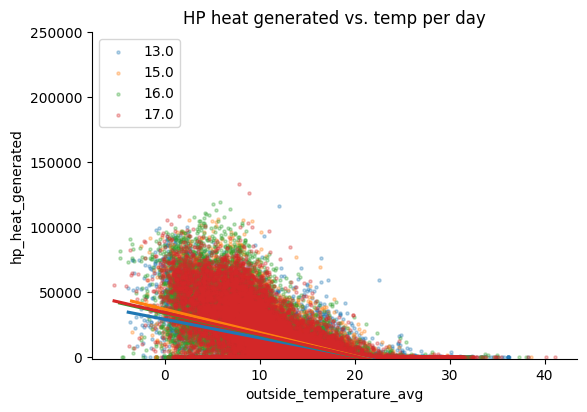

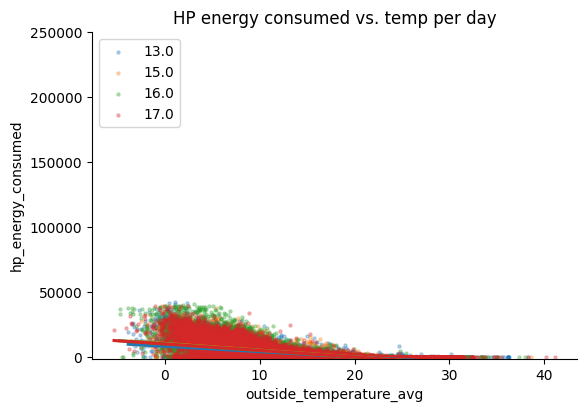

In [40]:
# scatter plot of heat demand per temperature including linear regression
sns.lmplot(x='outside_temperature_avg', y='hp_heat_generated', 
           data=df_cic, 
           hue='stookgrens',
           height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.title('HP heat generated vs. temp per day')
plt.ylim([-1000, 250000])
plt.show()
# scatter plot of heat demand per temperature including linear regression
sns.lmplot(x='outside_temperature_avg', y='hp_energy_consumed', 
           data=df_cic, 
           hue='stookgrens',
           height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.title('HP energy consumed vs. temp per day')
plt.ylim([-1000, 250000])
plt.show()

COP, perc-by-hp, & heat demand vs. outside temperature

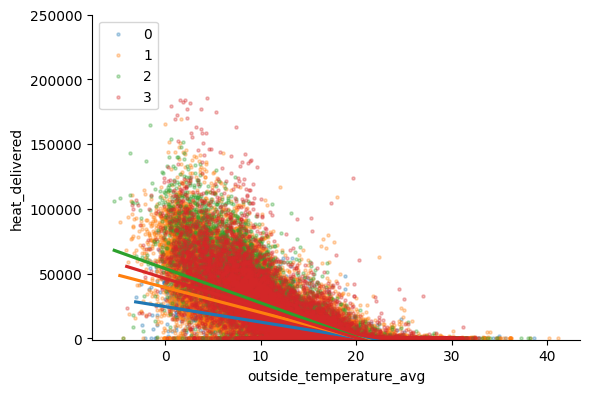

In [22]:


# scatter plot of heat demand per temperature including linear regression
sns.lmplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic, 
           hue='aardgas_verbruik_cat', height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

In [23]:
# for each cic where temperature is < 15 degrees calculate the average

In [24]:
# add percentage by hp
df_cic['perc_by_hp'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic['heat_delivered']).astype(float)
df_cic['COP'] = (df_cic[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)

(-0.1, 1.1)

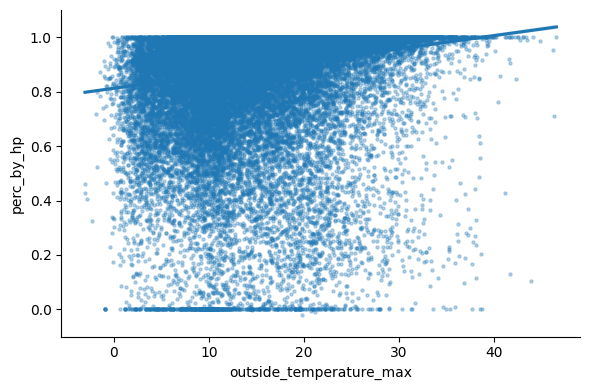

In [42]:
# scatter plot of perc_by_hp per temperature
sns.lmplot(x='outside_temperature_max', y='perc_by_hp', 
           data=df_cic[df_cic['heat_delivered']>1000], height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([-0.1, 1.1])

(0.0, 10.0)

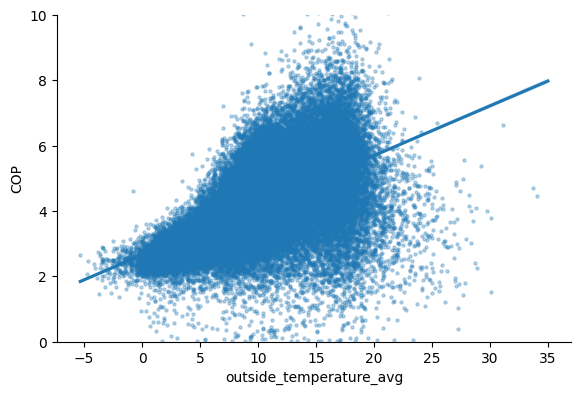

In [26]:
# scatter plot of COP per temperature
COP_temp = sns.lmplot(x='outside_temperature_avg', y='COP', 
           data=df_cic[(df_cic['COP']>0) & (df_cic['heat_delivered']>1000)], 
             height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,10])

In [27]:
# clean dataframe of cic data
df_cic_clean = (
    df_cic[
        (df_cic['COP']>0) 
        & (df_cic['heat_delivered']>1000)
        & (~df_cic['COP'].isna())
        & (~df_cic['perc_by_hp'].isna())
        & (~df_cic['heat_delivered'].isna())
        & (~df_cic['outside_temperature_avg'].isna())
    ]
)

# fit a linear regression model to heat_demand / outside_temperature_avg per cic
from sklearn.linear_model import LinearRegression


In [28]:
i = 0
for cicId in df_cic_clean['cic_id'].unique():
    nr_of_points = df_cic_clean[df_cic_clean['cic_id']==cicId].shape[0]
    X = df_cic_clean[df_cic_clean['cic_id']==cicId][['outside_temperature_avg']]
    y = df_cic_clean[df_cic_clean['cic_id']==cicId]['heat_delivered']
    reg = LinearRegression().fit(X, y)
    # print(f'cicId: {cicId}, number_of_points: {nr_of_points}, intercept: {reg.intercept_}, coeff: {reg.coef_[0]}')
    df_cic_clean.loc[df_cic_clean['cic_id']==cicId, 'heat_delivered_intercept'] = reg.intercept_
    df_cic_clean.loc[df_cic_clean['cic_id']==cicId, 'heat_delivered_coeff'] = reg.coef_[0]
    df_cic_clean.loc[df_cic_clean['cic_id']==cicId, 'heat_delivered_pred'] = reg.predict(X)
    df_cic_clean.loc[df_cic_clean['cic_id']==cicId, 'number_of_rows_per_cic'] = nr_of_points

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_83104/576496405.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic_clean.loc[df_cic_clean['cic_id']==cicId, 'heat_delivered_intercept'] = reg.intercept_
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_83104/576496405.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic_clean.loc[df_cic_clean['cic_id']==cicId, 'heat_delivered_coeff'] = reg.coef_[0]
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_83104/576496405.py:

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_83104/3028055151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic_clean['heat_delivered_intercept_cat'] = df_cic_clean['heat_delivered_intercept'].apply(lambda x: 0 if x < 40000 else (1 if x < 75000 else 2))
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_83104/3028055151.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cic_clean['heat_delivered_coeff_cat'] = df_cic_clean['heat_delivered_coeff'].apply(lambda x: 0 if x < -5

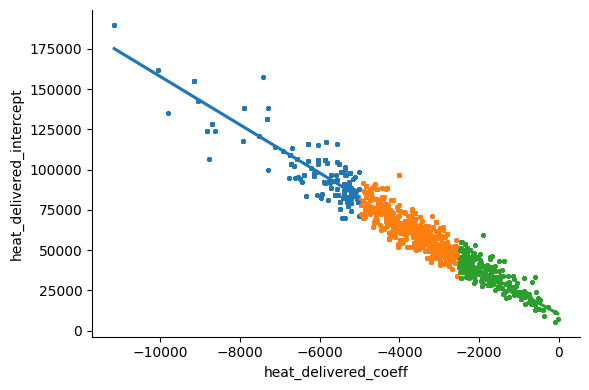

In [33]:
# heat delivered intercept < 40000, 40000-75000, > 75000
df_cic_clean['heat_delivered_intercept_cat'] = df_cic_clean['heat_delivered_intercept'].apply(lambda x: 0 if x < 40000 else (1 if x < 75000 else 2))

# heat delivered coeff < -5000, -5000 - -2500, > -2500
df_cic_clean['heat_delivered_coeff_cat'] = df_cic_clean['heat_delivered_coeff'].apply(lambda x: 0 if x < -5000 else (1 if x < -2500 else 2))

# scatter plot heat_delivered_coeff and heat_delivered_intercept
sns.lmplot(x='heat_delivered_coeff', y='heat_delivered_intercept', 
           data=df_cic_clean[df_cic_clean['number_of_rows_per_cic']>20], 
           hue='heat_delivered_coeff_cat', height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
# df_cic_clean[df_cic_clean['number_of_rows_per_cic']>20][['heat_delivered_coeff', 'heat_delivered_intercept']].plot()


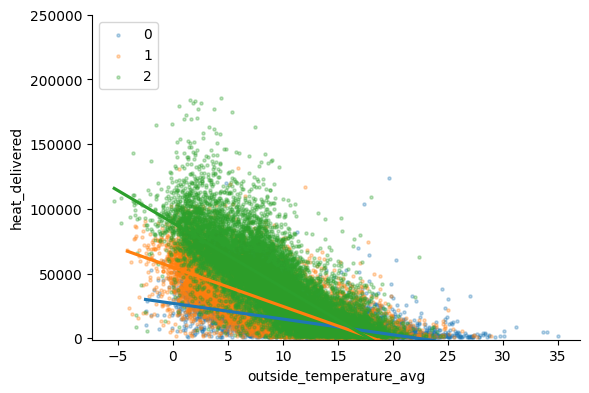

In [67]:
# scatter plot of heat demand per temperature including linear regression
sns.lmplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic_clean, 
           hue='heat_delivered_intercept_cat', height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

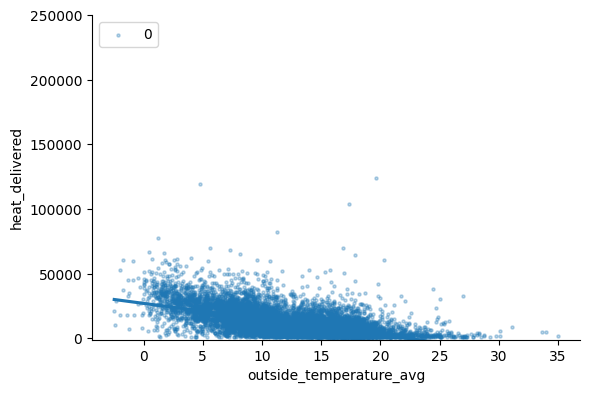

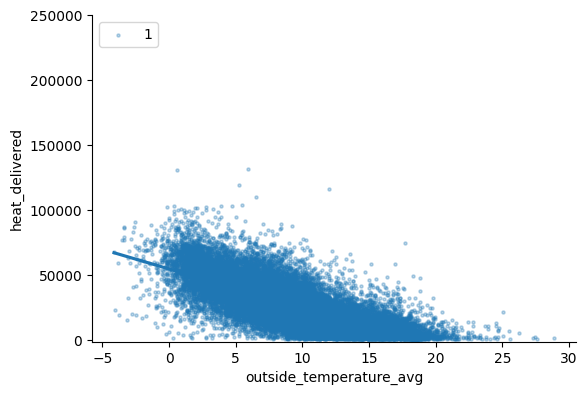

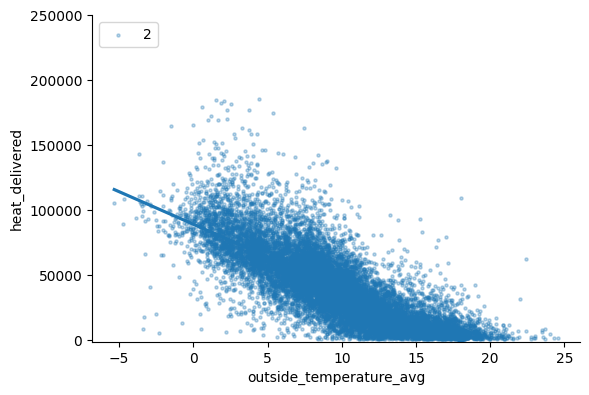

In [68]:
# scatter plot of heat demand per temperature including linear regression
sns.lmplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic_clean[df_cic_clean['heat_delivered_intercept_cat']==0], 
           hue='heat_delivered_intercept_cat', height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

sns.lmplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic_clean[df_cic_clean['heat_delivered_intercept_cat']==1], 
           hue='heat_delivered_intercept_cat', height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

sns.lmplot(x='outside_temperature_avg', y='heat_delivered', data=df_cic_clean[df_cic_clean['heat_delivered_intercept_cat']==2], 
           hue='heat_delivered_intercept_cat', height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.legend(loc='upper left')
plt.ylim([-1000, 250000])
plt.show()

## check which house parameters are the best predictors of the intercept and the coefficient

Text(0.5, 1.0, 'heat_delivered per temperature')

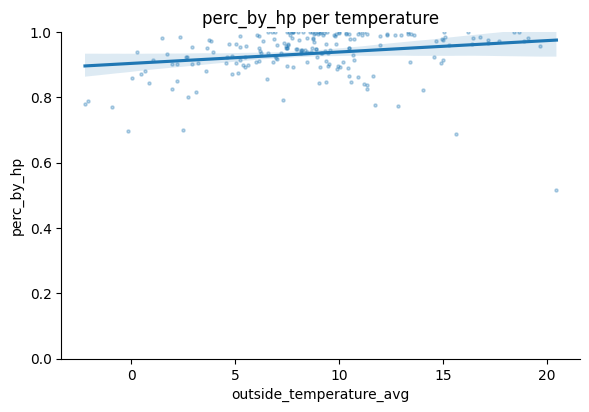

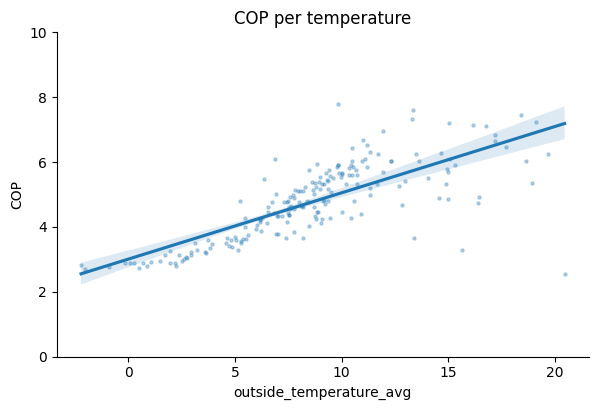

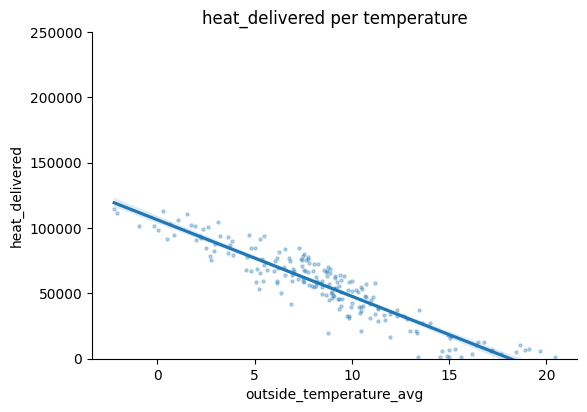

In [77]:
# scatter plot of perc_by_hp per temperature
sns.lmplot(x='outside_temperature_avg', y='perc_by_hp', 
           data=df_cic_clean[df_cic_clean['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0, 1])
plt.title('perc_by_hp per temperature')

# scatter plot of COP per temperature
COP_temp = sns.lmplot(x='outside_temperature_avg', y='COP', 
           data=df_cic_clean[df_cic_clean['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], 
             height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,10])
plt.title('COP per temperature')

# scatter plot of heat_delivered per temperature
COP_temp = sns.lmplot(x='outside_temperature_avg', y='heat_delivered', 
           data=df_cic_clean[df_cic_clean['cic_id']=='CIC-17fcd27d-dbd7-561c-887e-faf59bb9ebeb'], 
             height=4, aspect=1.5, legend=False,
           scatter_kws={"s": 5, "alpha": 0.3})
plt.ylim([0,250000])
plt.title('heat_delivered per temperature')

In [101]:
# make df_cic_summary which counts nr of rows per cic and sums heat_delivered
df_cic_summary = df_cic.groupby('cic_id').agg({'heat_delivered': 'sum', 
                                               'hp1_heat_generated': 'sum',
                                                'hp2_heat_generated': 'sum',
                                                'boiler_heat_generated': 'sum',
                                                'hp1_energy_consumed': 'sum',
                                                'hp2_energy_consumed': 'sum',
                                               'date': 'count'}).reset_index()
df_cic_summary['perc_by_hp'] = (df_cic_summary[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / df_cic_summary['heat_delivered']).astype(float)
df_cic_summary['COP'] = (df_cic_summary[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1) / (df_cic_summary[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1))).astype(float)
df_cic_summary['hp_heat_generated'] = df_cic_summary[['hp1_heat_generated', 'hp2_heat_generated']].sum(axis=1)
df_cic_summary['hp_energy_consumed'] = df_cic_summary[['hp1_energy_consumed', 'hp2_energy_consumed']].sum(axis=1)

Text(0, 0.5, 'Number of CICs')

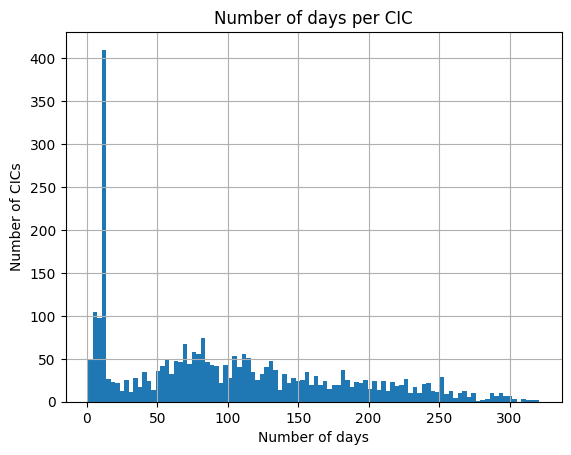

In [96]:
# nr. of days per cic
df_cic_summary['date'].hist(bins=100)
plt.title('Number of days per CIC')
plt.xlabel('Number of days')
plt.ylabel('Number of CICs')

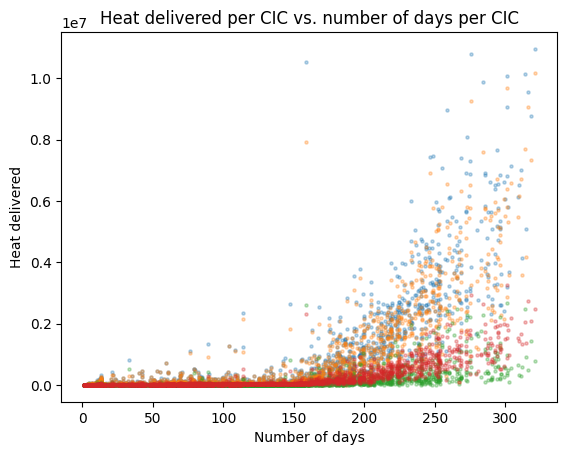

In [102]:
# scatter heat delivered per cic vs. nr of days per cic
plt.scatter(df_cic_summary['date'], df_cic_summary['heat_delivered'], s=5, alpha=0.3)
plt.scatter(df_cic_summary['date'], df_cic_summary['hp_heat_generated'], s=5, alpha=0.3)
plt.scatter(df_cic_summary['date'], df_cic_summary['boiler_heat_generated'], s=5, alpha=0.3)
plt.scatter(df_cic_summary['date'], df_cic_summary['hp_energy_consumed'], s=5, alpha=0.3)
plt.title('Heat delivered per CIC vs. number of days per CIC')
plt.xlabel('Number of days')
plt.ylabel('Heat delivered')
plt.show()

# Fit trendlines through each of the scatters
# heat delivered
x = df_cic_summary['date']
y = df_cic_summary['heat_delivered']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)

# scatter heat by hp delivered vs. nr of days per cic

# plt.title('Heat by HP delivered per CIC vs. number of days per CIC')
# plt.xlabel('Number of days')
# plt.ylabel('Heat by HP delivered')
# plt.show()

# scatter boiler heat generated  vs. nr of days per cic

# plt.title('Boiler heat generated per CIC vs. number of days per CIC')
# plt.xlabel('Number of days')
# plt.ylabel('Boiler heat generated')


Test with dbscan

In [115]:
X = df_cic_clean[['outside_temperature_avg', 'perc_by_hp', 'heat_delivered','COP']].values
# Standardize the data
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=10, min_samples=20)
clusters = dbscan.fit_predict(scaled_X)

# count number of different clusters
print(np.unique(clusters, return_counts=True))

# Plot result
plt.scatter(scaled_X[:,0], scaled_X[:,2], c=clusters, cmap='plasma')

(array([-1,  0]), array([   52, 56512]))


In [68]:
# create array with temperatures -5 - 35
temps = [i for i in range(-5, 36)]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    df_cic_clean['outside_temperature_avg'],
    df_cic_clean['COP'])
print(slope, intercept)

0.15221949504495377 2.6517109233687552


# explorative analysis

,id,created_at,updated_at,deal_id,orderNr,aanbevolen_vermogen_warmtepomp,referentie_warmtevraag_per_m2,geschiktheid_woning,aardgas_verbruik,bouwjaar,...,elektriciteit,gas,kosten_extra_elektra_verbruik,besparing_minder_gas_verbruik,besparing,investering,subsidie,netto_kosten,terugverdientijd,terugverdientijd_jaren
0,1,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT3906,4,67.00,goed geschikt,450.0,Na 2000,...,0.60,2.31,249.12,441.79,192.67,4849.0,2700.0,2149.0,11 jaar en 2 maanden,11.15
1,2,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT6324,4,72.38,goed geschikt,1559.0,Tussen 1970 en 1990,...,0.40,1.45,835.47,1395.03,559.56,5199.0,2700.0,2499.0,4 jaar en 6 maanden,4.47
2,3,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT4133,4,77.75,goed geschikt,1250.0,Tussen 1970 en 1990,...,0.60,2.31,1022.85,1813.91,791.06,4849.0,2700.0,2149.0,2 jaar en 9 maanden,2.72
3,4,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT2495,4,67.00,goed geschikt,1534.0,Na 2000,...,0.60,2.31,1191.29,2112.61,921.33,4849.0,2700.0,2149.0,2 jaar en 4 maanden,2.33
4,5,2023-09-07 15:24:49,2023-09-07 15:24:49,2147483647,QUATT1970,4,67.00,uitmuntend,1400.0,Voor 1970,...,0.40,1.45,683.49,1318.78,635.29,4849.0,2700.0,2149.0,3 jaar en 5 maanden,3.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2869,2870,2023-09-08 10:02:42,2023-09-08 10:02:42,2147483647,QUATT1503,4,67.00,uitmuntend,1600.0,Voor 1970,...,0.60,2.31,1184.95,2428.25,1243.30,4849.0,2700.0,2149.0,1 jaar en 9 maanden,1.73
2870,2871,2023-09-08 10:02:42,2023-09-08 10:02:42,2147483647,QUATT1259,4,80.44,matig geschikt,2000.0,Voor 1970,...,0.60,2.31,938.67,1479.67,541.00,4849.0,2700.0,2149.0,3 jaar en 12 maanden,3.97
2871,2872,2023-09-08 10:02:42,2023-09-08 10:02:42,2147483647,QUATT25,4,67.00,goed geschikt,1668.0,Voor 1970,...,0.73,3.27,1634.24,3371.96,1737.72,4299.0,2700.0,1599.0,en 12 maanden,0.92
2872,2873,2023-09-08 10:02:42,2023-09-08 10:02:42,2147483647,QUATT2769,8,88.50,zeer geschikt,3000.0,Tussen 1970 en 1990,...,0.40,1.45,1641.94,2985.32,1343.38,8349.0,5400.0,2949.0,2 jaar en 3 maanden,2.20


In [ ]:
# make sure that there is a seperation between estimating savings for new customers and validating savings for existing customers

# linear regression of houses is calculated in advance: rated house power demand, coefficient and t_cutoff which is the intercept with the x_axis

# COP: 
# - improvement 1: model per hour instead of per day
# - improvement 2: Don't model COP, but model COP / (heat delivered) total. try with heat devivered total and per hp.